Loading data...

Generating individual plots for activity: 7
Subject subject1: Processing 2922 samples...
Displaying plot for subject1 (Detected 41 events)


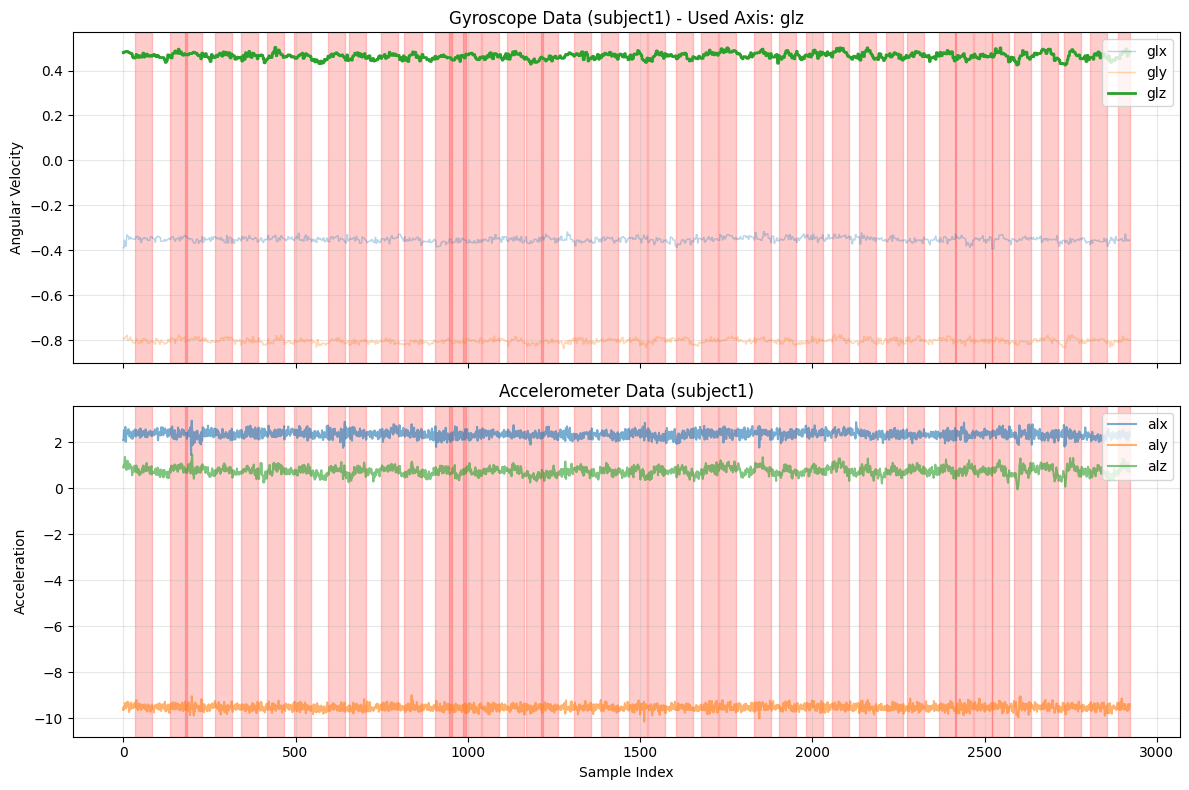

--------------------------------------------------
Subject subject2: Processing 3178 samples...
Displaying plot for subject2 (Detected 19 events)


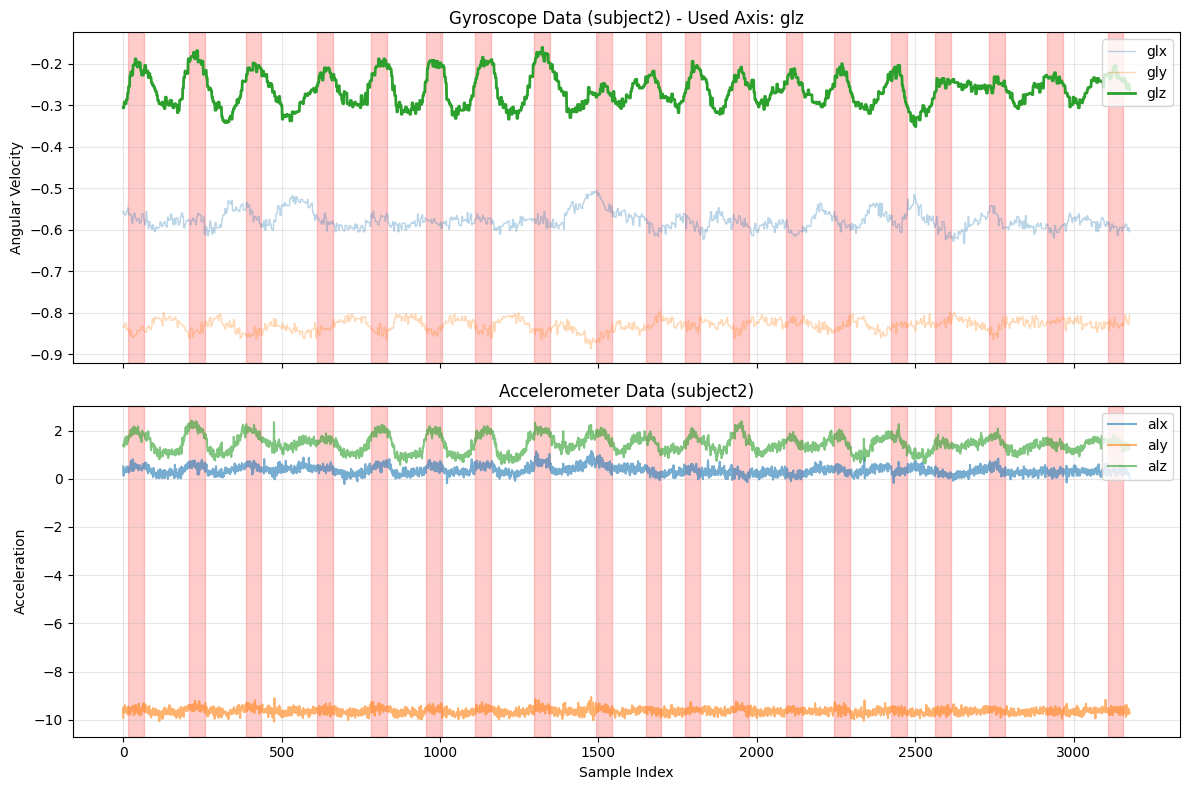

--------------------------------------------------
Subject subject3: Processing 3229 samples...
Displaying plot for subject3 (Detected 44 events)


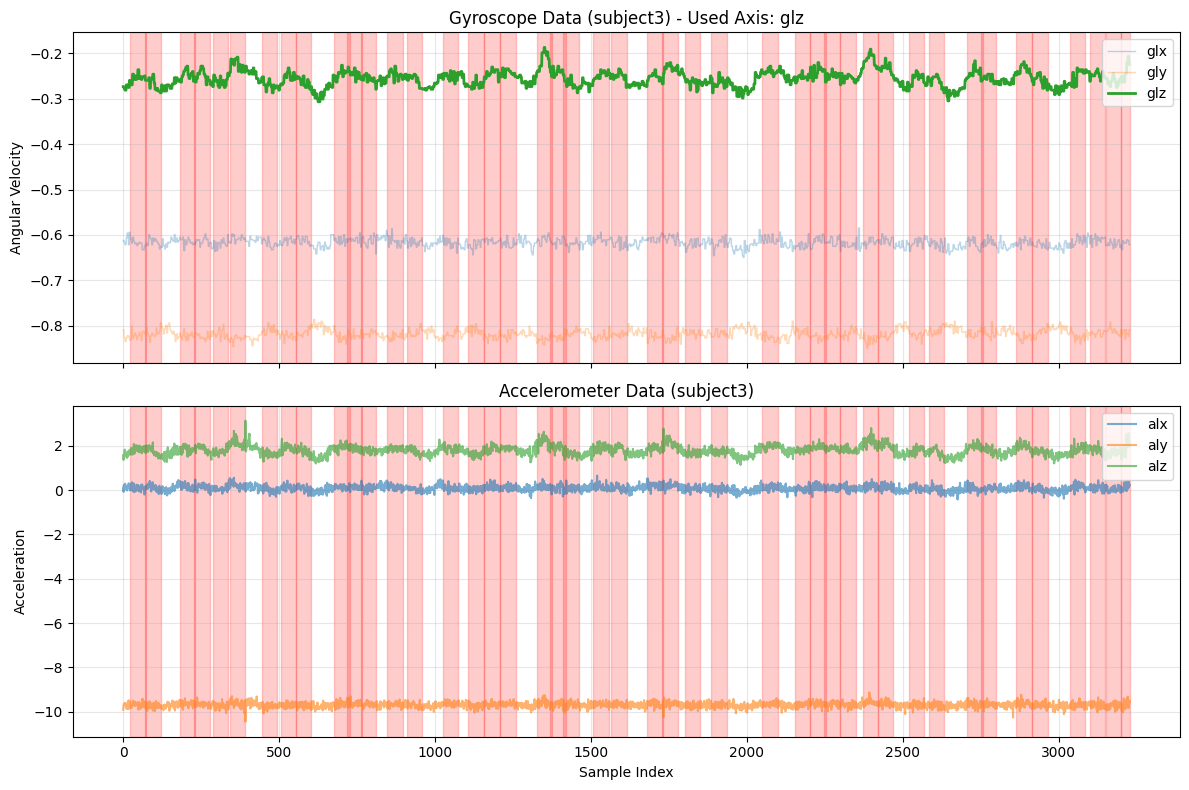

--------------------------------------------------
Subject subject4: Processing 3127 samples...
Displaying plot for subject4 (Detected 46 events)


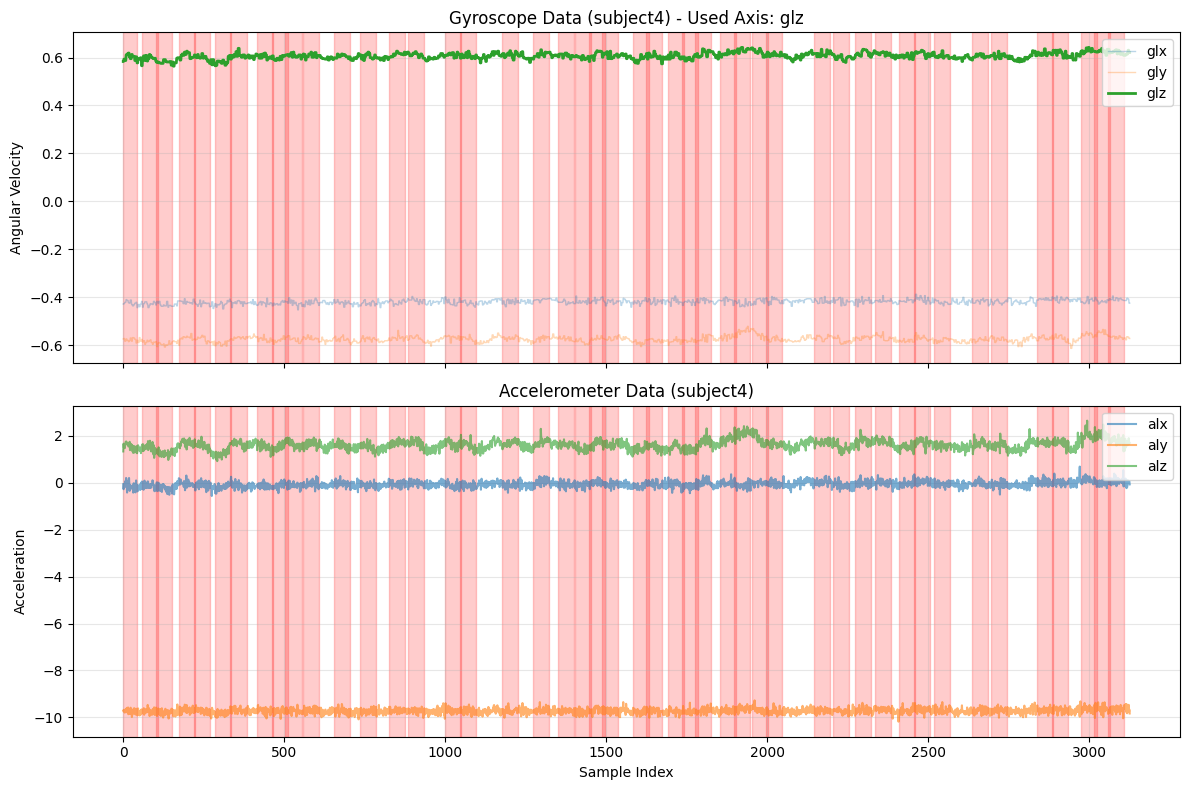

--------------------------------------------------
Subject subject5: Processing 2718 samples...
Displaying plot for subject5 (Detected 41 events)


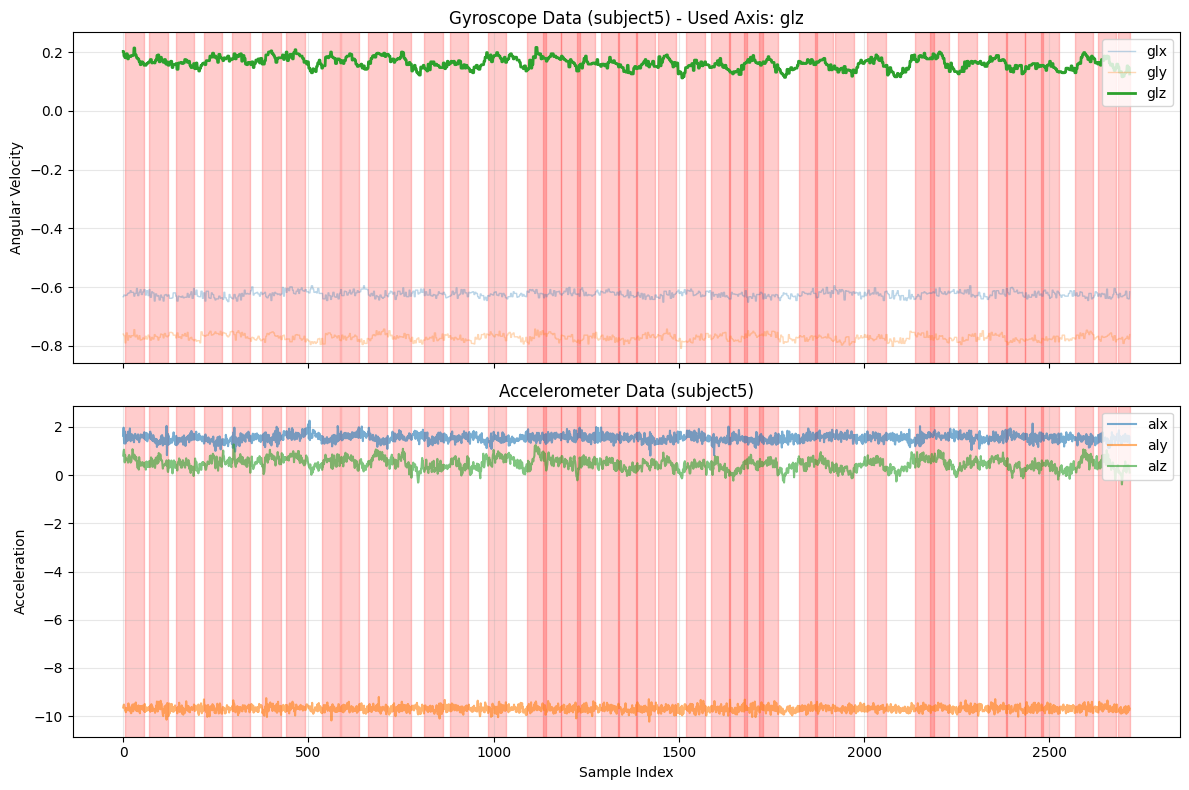

--------------------------------------------------
Subject subject6: Processing 1949 samples...
Displaying plot for subject6 (Detected 26 events)


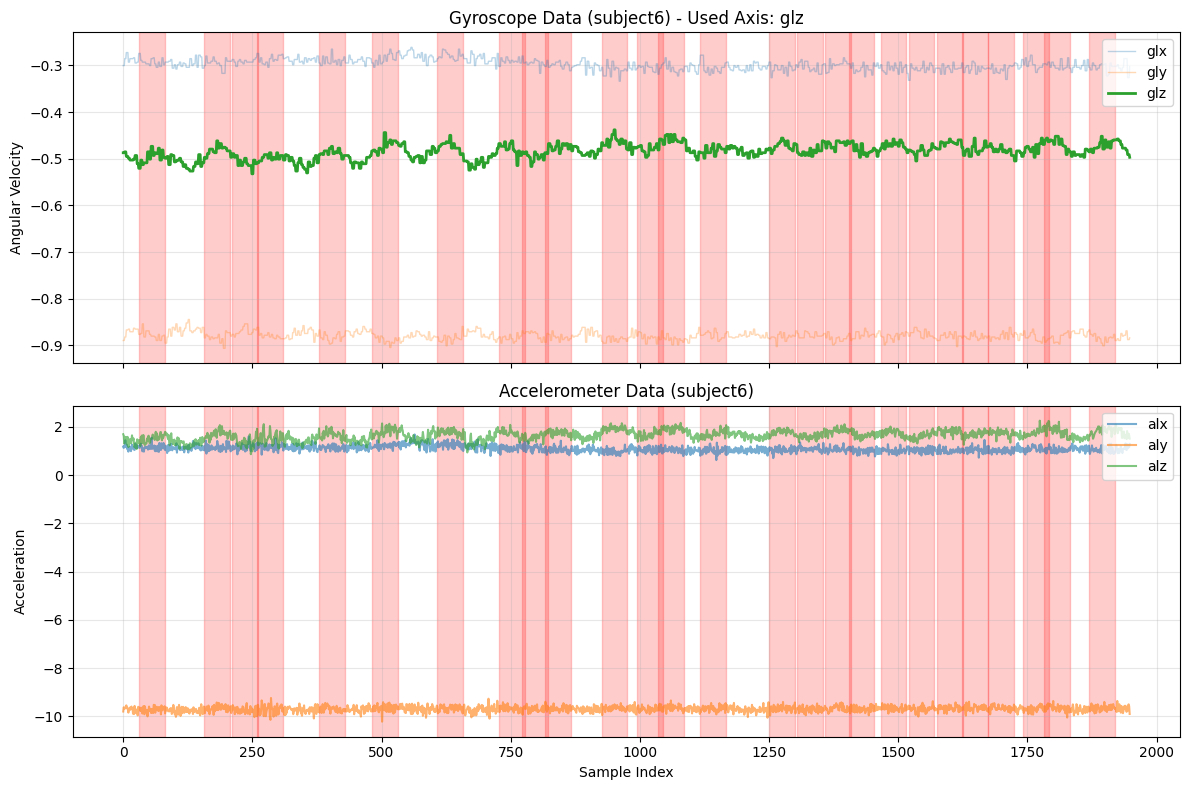

--------------------------------------------------
Subject subject7: Processing 2615 samples...
Displaying plot for subject7 (Detected 40 events)


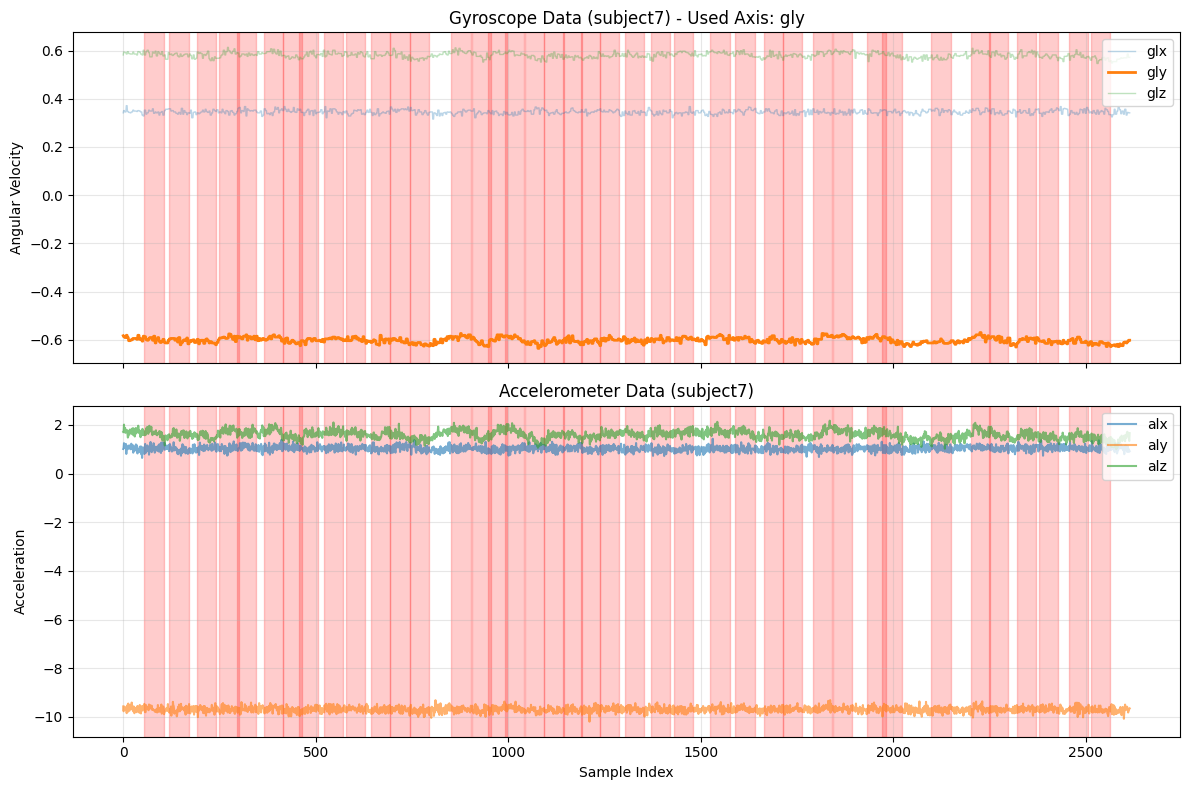

--------------------------------------------------
Subject subject8: Processing 2871 samples...
Displaying plot for subject8 (Detected 31 events)


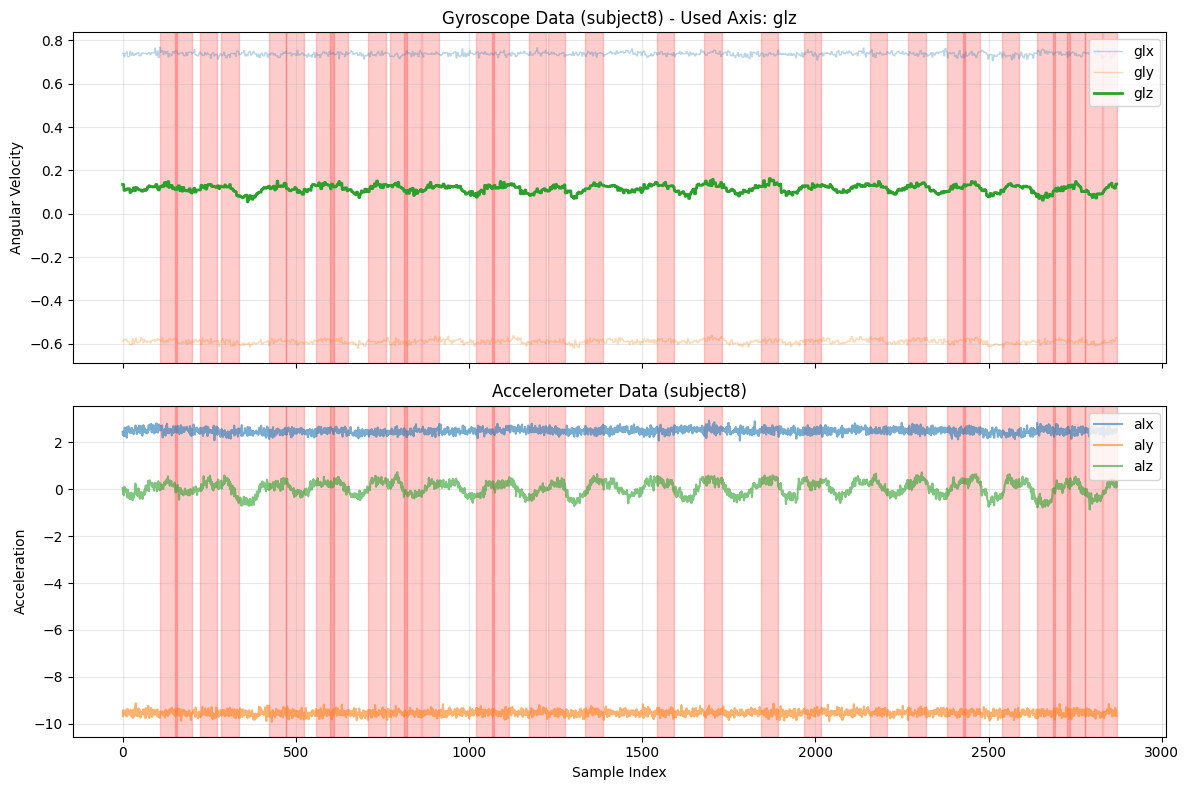

--------------------------------------------------
Subject subject9: Processing 2717 samples...
Displaying plot for subject9 (Detected 44 events)


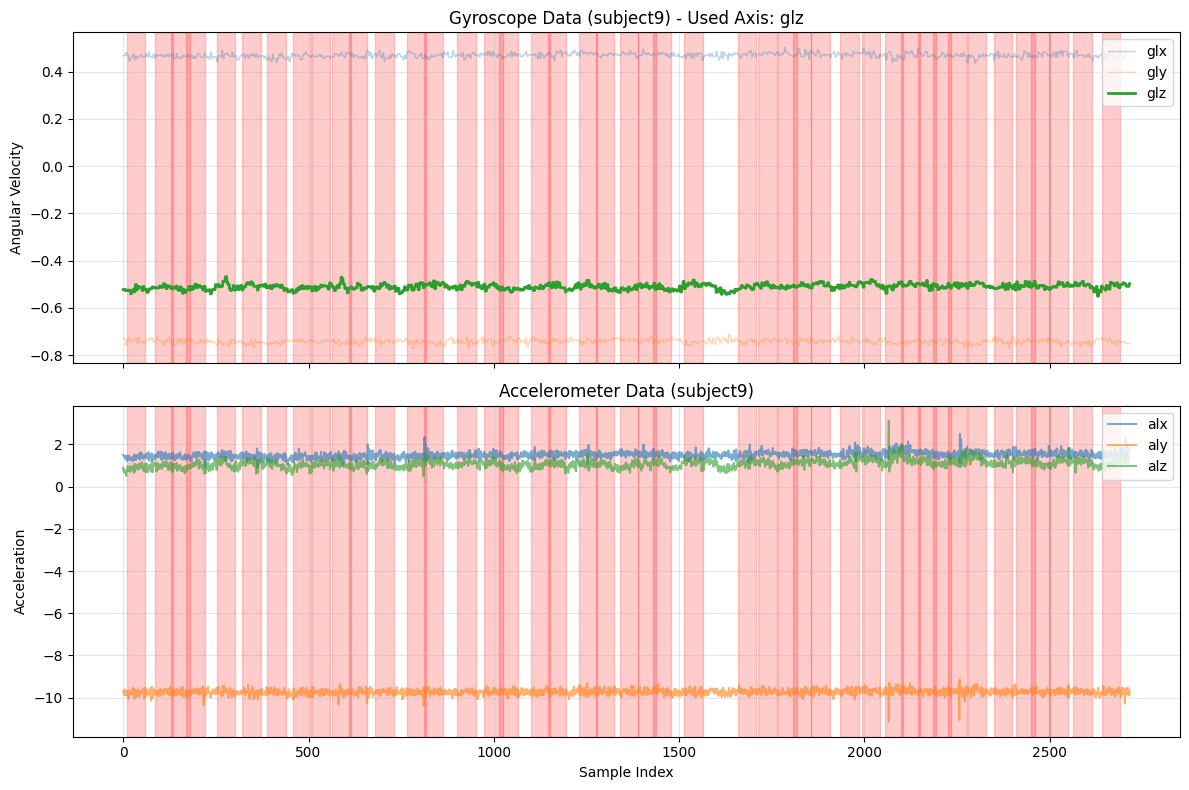

--------------------------------------------------
Subject subject10: Processing 2615 samples...
Displaying plot for subject10 (Detected 42 events)


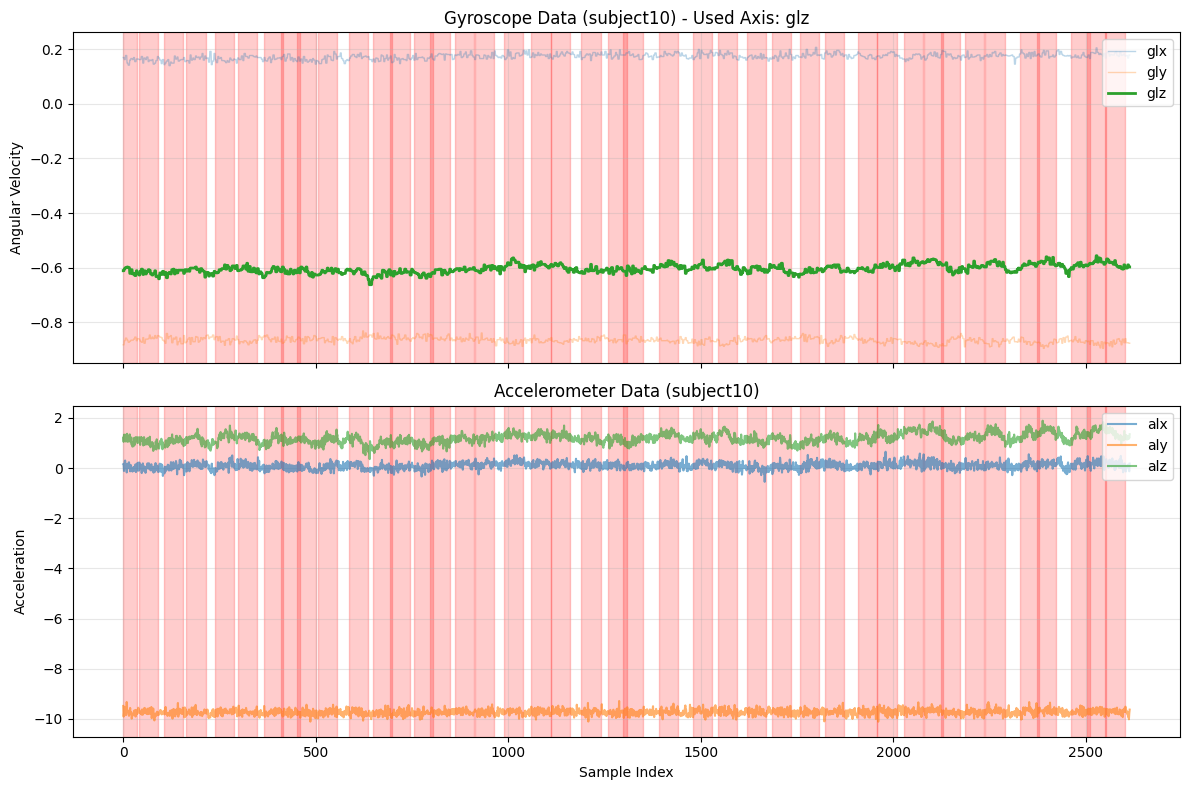

--------------------------------------------------

Generating comparison plot for all subjects
Displaying comparison plot for all subjects


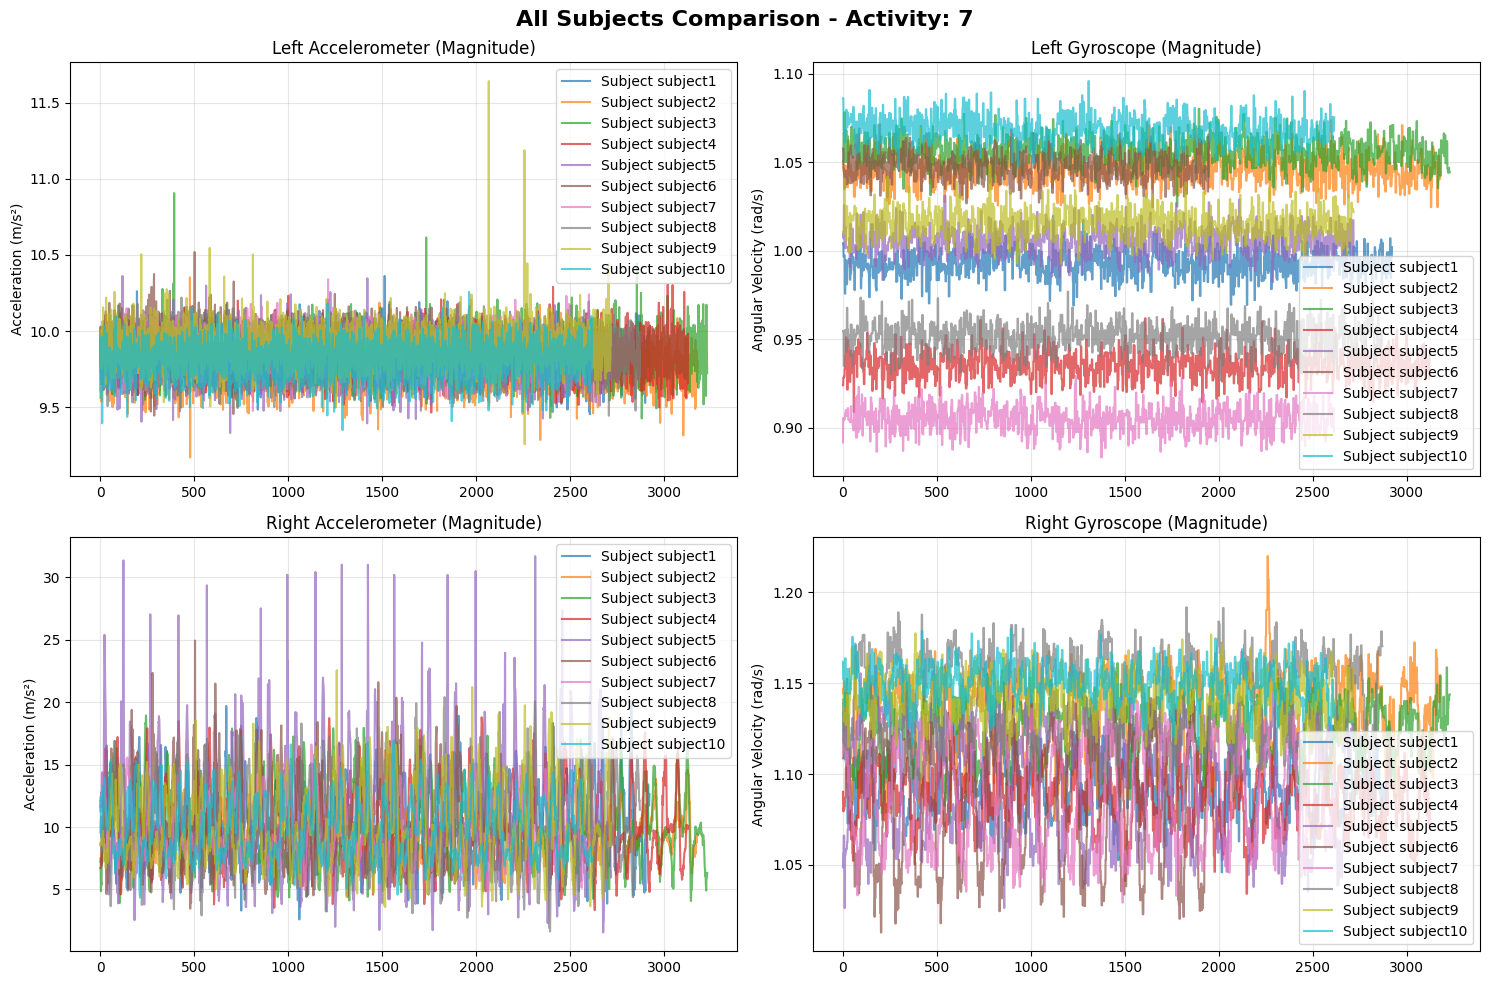


Visualization completed!


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import find_peaks

# ==========================================
# 전역 설정
# ==========================================
FS = 50                  # mHealth 센서 샘플링 주파수 (Hz)
CRUNCH_WIN_SEC = 1.0     # crunch 1회 길이를 대략 1.0초로 가정
MIN_DISTANCE_SEC = 0.8   # crunch 사이 최소 간격 (초 단위)
PROMINENCE_SCALE = 0.8   # 표준편차 배수 (피크 검출 민감도)

def load_data(file_path):
    """CSV 파일을 읽어 DataFrame으로 반환"""
    df = pd.read_csv(file_path)
    return df

def detect_crunch_intervals_by_peaks(subject_data,
                                     fs=FS,
                                     win_sec=CRUNCH_WIN_SEC,
                                     min_distance_sec=MIN_DISTANCE_SEC,
                                     prominence_scale=PROMINENCE_SCALE):
    """
    glx, gly, glz 중 표준편차가 가장 큰 축을 골라
    피크 기준 [start_idx, end_idx] 리스트와 사용한 축 이름을 반환
    """
    # 1) 축 자동 선택: 가장 많이 흔들리는 축
    cand_axes = ['glx', 'gly', 'glz']
    stds = [subject_data[a].std() for a in cand_axes]
    axis = cand_axes[int(np.argmax(stds))]  # 가장 많이 흔들리는 축

    signal = subject_data[axis].values
    distance = int(min_distance_sec * fs)

    # 2) prominence를 절대값이 아니라, "표준편차의 몇 배"로 설정
    prominence = prominence_scale * np.std(signal)

    peaks, _ = find_peaks(signal,
                          distance=distance,
                          prominence=prominence)

    half_win = int((win_sec * fs) / 2)
    intervals = []
    n = len(signal)
    for p in peaks:
        start = max(0, p - half_win)
        end   = min(n - 1, p + half_win)
        intervals.append((start, end))

    return intervals, axis

def plot_subject_activity(df, activity, trim_start=0, trim_end=0):
    """
    개별 사용자의 활동 데이터를 플롯하고, 검출된 Crunch 구간을 표시함.
    (저장하지 않고 plt.show()로 화면에 표시)
    """
    activity_df = df[df['Activity'] == activity].copy()
    subjects = activity_df['subject'].unique()

    for subject in subjects:
        subject_data = activity_df[activity_df['subject'] == subject]

        # --- [데이터 자르기 로직] ---
        if len(subject_data) > (trim_start + trim_end):
            if trim_end > 0:
                subject_data = subject_data.iloc[trim_start:-trim_end]
            else:
                subject_data = subject_data.iloc[trim_start:]

        print(f"Subject {subject}: Processing {len(subject_data)} samples...")

        # 인덱스 리셋
        subject_data = subject_data.reset_index(drop=True)
        time_index = np.arange(len(subject_data))

        # ---------- 피크 기반 crunch 구간 검출 -------------
        crunch_intervals, used_axis = detect_crunch_intervals_by_peaks(
            subject_data,
            fs=FS,
            win_sec=CRUNCH_WIN_SEC,
            min_distance_sec=MIN_DISTANCE_SEC,
            prominence_scale=PROMINENCE_SCALE
        )
        # ---------------------------------------------------

        # 그래프 그리기 (가속도계 + 자이로스코프)
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # Plot 1: Gyroscope
        for ax_name in ['glx', 'gly', 'glz']:
            alpha_val = 1.0 if ax_name == used_axis else 0.3
            width_val = 2.0 if ax_name == used_axis else 1.0
            axes[0].plot(time_index, subject_data[ax_name],
                         label=ax_name, alpha=alpha_val, linewidth=width_val)

        axes[0].set_title(f'Gyroscope Data ({subject}) - Used Axis: {used_axis}')
        axes[0].set_ylabel('Angular Velocity')
        axes[0].legend(loc='upper right')
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Accelerometer
        for ax_name in ['alx', 'aly', 'alz']:
            axes[1].plot(time_index, subject_data[ax_name], label=ax_name, alpha=0.6)

        axes[1].set_title(f'Accelerometer Data ({subject})')
        axes[1].set_ylabel('Acceleration')
        axes[1].set_xlabel('Sample Index')
        axes[1].legend(loc='upper right')
        axes[1].grid(True, alpha=0.3)

        # 검출된 구간 박스 표시
        for (start, end) in crunch_intervals:
            axes[0].axvspan(start, end, color='red', alpha=0.2)
            axes[1].axvspan(start, end, color='red', alpha=0.2)

        plt.tight_layout()
        print(f"Displaying plot for {subject} (Detected {len(crunch_intervals)} events)")
        plt.show()  # <--- 저장 대신 표시
        print("-" * 50)


def plot_all_subjects_combined(df, activity='croch', trim_start=0, trim_end=0):
    """
    모든 사용자의 데이터를 하나의 플롯에 표시 (비교용)
    (저장하지 않고 plt.show()로 화면에 표시)
    """
    activity_df = df[df['Activity'] == activity].copy()

    if len(activity_df) == 0:
        print(f"Warning: No data found for activity '{activity}'")
        return

    subjects = activity_df['subject'].unique()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'All Subjects Comparison - Activity: {activity}',
                 fontsize=16, fontweight='bold')

    for subject in subjects:
        subject_data = activity_df[activity_df['subject'] == subject]

        # --- [데이터 자르기 로직] ---
        if len(subject_data) > (trim_start + trim_end):
            if trim_end > 0:
                subject_data = subject_data.iloc[trim_start:-trim_end]
            else:
                subject_data = subject_data.iloc[trim_start:]
        # -------------------------

        time_index = np.arange(len(subject_data))

        # Left Accelerometer (magnitude)
        al_mag = np.sqrt(subject_data['alx']**2 +
                         subject_data['aly']**2 +
                         subject_data['alz']**2)
        axes[0, 0].plot(time_index, al_mag,
                        label=f'Subject {subject}', alpha=0.7)

        # Left Gyroscope (magnitude)
        gl_mag = np.sqrt(subject_data['glx']**2 +
                         subject_data['gly']**2 +
                         subject_data['glz']**2)
        axes[0, 1].plot(time_index, gl_mag,
                        label=f'Subject {subject}', alpha=0.7)

        # Right Accelerometer (magnitude)
        ar_mag = np.sqrt(subject_data['arx']**2 +
                         subject_data['ary']**2 +
                         subject_data['arz']**2)
        axes[1, 0].plot(time_index, ar_mag,
                        label=f'Subject {subject}', alpha=0.7)

        # Right Gyroscope (magnitude)
        gr_mag = np.sqrt(subject_data['grx']**2 +
                         subject_data['gry']**2 +
                         subject_data['grz']**2)
        axes[1, 1].plot(time_index, gr_mag,
                        label=f'Subject {subject}', alpha=0.7)

    axes[0, 0].set_title('Left Accelerometer (Magnitude)')
    axes[0, 0].set_ylabel('Acceleration (m/s²)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_title('Left Gyroscope (Magnitude)')
    axes[0, 1].set_ylabel('Angular Velocity (rad/s)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].set_title('Right Accelerometer (Magnitude)')
    axes[1, 0].set_ylabel('Acceleration (m/s²)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_title('Right Gyroscope (Magnitude)')
    axes[1, 1].set_ylabel('Angular Velocity (rad/s)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    print(f"Displaying comparison plot for all subjects")
    plt.show() # <--- 저장 대신 표시


def main():
    # 경로를 본인 환경에 맞게 수정하세요
    file_path = '/content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv'

    # 데이터 로드
    print("Loading data...")
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return

    df = load_data(file_path)

    # ==========================================
    # [설정] 활동 및 자를 구간 설정
    # ==========================================
    ACTIVITY = 7       # 분석할 활동 번호 (또는 'croch' 등)
    TRIM_START = 100   # 앞에서 제거할 샘플 수 (예: 50Hz 기준 2초 = 100)
    TRIM_END = 50      # 뒤에서 제거할 샘플 수
    # ==========================================

    # 각 사용자별 개별 플롯 표시
    print(f"\nGenerating individual plots for activity: {ACTIVITY}")
    plot_subject_activity(
        df,
        activity=ACTIVITY,
        trim_start=TRIM_START,
        trim_end=TRIM_END
    )

    # 모든 사용자 비교 플롯 표시
    print(f"\nGenerating comparison plot for all subjects")
    plot_all_subjects_combined(
        df,
        activity=ACTIVITY,
        trim_start=TRIM_START,
        trim_end=TRIM_END
    )

    print("\nVisualization completed!")

if __name__ == "__main__":
    main()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# CSV 파일 읽기
def load_data(file_path):
    """CSV 파일을 읽어 DataFrame으로 반환"""
    df = pd.read_csv(file_path)
    return df

from scipy.signal import find_peaks

# ================= 전역 설정 =================
FS = 50                  # mHealth 샘플링 주파수(Hz)
CRUNCH_WIN_SEC = 1.0     # crunch 1회 길이(초)
MIN_DISTANCE_SEC = 0.8   # crunch 사이 최소 간격(초)
PROMINENCE_SCALE = 0.8   # 피크 prominence = std * 이 값
# ===========================================


def detect_crunch_intervals_by_peaks(subject_data,
                                     fs=FS,
                                     win_sec=CRUNCH_WIN_SEC,
                                     min_distance_sec=MIN_DISTANCE_SEC,
                                     prominence_scale=PROMINENCE_SCALE):
    """
    왼손 자이로(glx, gly, glz) 중 가장 많이 흔들리는 축을 선택해서,
    피크 기준으로 [start_idx, end_idx] 리스트를 반환
    """
    cand_axes = ['glx', 'gly', 'glz']
    stds = [subject_data[a].std() for a in cand_axes]
    axis = cand_axes[int(np.argmax(stds))]  # 가장 std 큰 축 선택

    signal = subject_data[axis].values
    distance = int(min_distance_sec * fs)
    prominence = prominence_scale * np.std(signal)

    peaks, _ = find_peaks(signal,
                          distance=distance,
                          prominence=prominence)

    half_win = int((win_sec * fs) / 2)
    intervals = []
    n = len(signal)
    for p in peaks:
        start = max(0, p - half_win)
        end = min(n - 1, p + half_win)
        intervals.append((start, end))

    return intervals, axis


def plot_all_subjects_combined(df, activity='croch', save_dir='plots', trim_start=0, trim_end=0):
    """
    모든 사용자의 데이터를 하나의 플롯에 표시 (비교용) - 구간 자르기 포함
    """
    activity_df = df[df['Activity'] == activity].copy()

    if len(activity_df) == 0:
        print(f"Warning: No data found for activity '{activity}'")
        return

    subjects = activity_df['subject'].unique()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'All Subjects Comparison - Activity: {activity}', fontsize=16, fontweight='bold')

    for subject in subjects:
        subject_data = activity_df[activity_df['subject'] == subject]

        # --- [데이터 자르기 로직] ---
        if len(subject_data) > (trim_start + trim_end):
            if trim_end > 0:
                subject_data = subject_data.iloc[trim_start:-trim_end]
            else:
                subject_data = subject_data.iloc[trim_start:]
        # -------------------------

        time_index = np.arange(len(subject_data))

        # Left Accelerometer (magnitude)
        al_mag = np.sqrt(subject_data['alx']**2 + subject_data['aly']**2 + subject_data['alz']**2)
        axes[0, 0].plot(time_index, al_mag, label=f'Subject {subject}', alpha=0.7)

        # Left Gyroscope (magnitude)
        gl_mag = np.sqrt(subject_data['glx']**2 + subject_data['gly']**2 + subject_data['glz']**2)
        axes[0, 1].plot(time_index, gl_mag, label=f'Subject {subject}', alpha=0.7)

        # Right Accelerometer (magnitude)
        ar_mag = np.sqrt(subject_data['arx']**2 + subject_data['ary']**2 + subject_data['arz']**2)
        axes[1, 0].plot(time_index, ar_mag, label=f'Subject {subject}', alpha=0.7)

        # Right Gyroscope (magnitude)
        gr_mag = np.sqrt(subject_data['grx']**2 + subject_data['gry']**2 + subject_data['grz']**2)
        axes[1, 1].plot(time_index, gr_mag, label=f'Subject {subject}', alpha=0.7)

    axes[0, 0].set_title('Left Accelerometer (Magnitude)')
    axes[0, 0].set_xlabel('Sample Index')
    axes[0, 0].set_ylabel('Acceleration (m/s²)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_title('Left Gyroscope (Magnitude)')
    axes[0, 1].set_xlabel('Sample Index')
    axes[0, 1].set_ylabel('Angular Velocity (rad/s)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].set_title('Right Accelerometer (Magnitude)')
    axes[1, 0].set_xlabel('Sample Index')
    axes[1, 0].set_ylabel('Acceleration (m/s²)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_title('Right Gyroscope (Magnitude)')
    axes[1, 1].set_xlabel('Sample Index')
    axes[1, 1].set_ylabel('Angular Velocity (rad/s)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    save_path = os.path.join(save_dir, f'all_subjects_{activity}_comparison.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved comparison plot: {save_path}")

    plt.show()
    plt.close()

def main():
    file_path = '/content/drive/MyDrive/Colab Notebooks/MHEALTH/mhealth_raw_data.csv'

    # 데이터 로드
    print("Loading data...")
    df = load_data(file_path)

    # ==========================================
    # [설정] 활동 및 자를 구간 설정
    # ==========================================
    ACTIVITY = 6       # 분석할 활동 번호
    TRIM_START = 100   # 앞에서 제거할 샘플 수 (예: 50Hz 기준 2초 = 100)
    TRIM_END = 50      # 뒤에서 제거할 샘플 수
    # ==========================================

    # 각 사용자별 개별 플롯 생성
    print(f"\nGenerating individual plots for activity: {ACTIVITY}")
    plot_subject_activity(
        df,
        activity=ACTIVITY,
        save_dir='plots',
        trim_start=TRIM_START,
        trim_end=TRIM_END
    )

    # 모든 사용자 비교 플롯 생성
    print(f"\nGenerating comparison plot for all subjects")
    plot_all_subjects_combined(
        df,
        activity=ACTIVITY,
        save_dir='plots',
        trim_start=TRIM_START,
        trim_end=TRIM_END
    )

    print("\nVisualization completed!")

if __name__ == "__main__":
    main()

Loading data...

Generating individual plots for activity: 6
Subject subject1: Trimmed data to 2922 samples.


TypeError: detect_crunch_intervals_by_peaks() got an unexpected keyword argument 'axis'